## Import packages

In [9]:
import numpy as np 
import csv 
import glob
import pandas as pd
import os
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
import ast
import seaborn as sns 
import matplotlib.pyplot as plt

## Select AI model type, dataset and drift rate model for AI_ddm

In [4]:
mtype = 0 # 0, 1, 2 or 3 (only relevant if model = AI or AI_ddm)
drmtype = "linear" # Drift rate model: linear, sigmoid, sigmoid_single_v_mod, sigmoid_single_v_max
n_starts = 35 # Number of random starting parameter values in parameter fitting.
dataset = 'magic_carpet_2020' 

# Load dataset

In [5]:
# Path to dataset

current_dir = os.getcwd()

if dataset == 'magic_carpet_2023':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/task_behaviour'))

    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*story.csv"))

elif dataset == 'magic_carpet_2020':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/choices'))


    
    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*game.csv"))

    
# Create an empty list to hold the dataframes
df_list = []

par_ids = []

# Loop through each file
for file_path in file_paths:
    # Extract the participant ID from the filename (assuming filename format like 001_story.csv)
    participant_id_str = os.path.basename(file_path).split('_')[0]
    
    participant_id = int(participant_id_str)

    if dataset == 'magic_carpet_2020' and participant_id == 4960: # Avoid outlier participant
        continue
        
    par_ids.append(participant_id)
    
    # Read the CSV file into a dataframe
    df = pd.read_csv(file_path)
    
    # Add the ParticipantID column
    df['ParticipantID'] = participant_id
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into one
df_empirical_data = pd.concat(df_list, ignore_index=True)


n_par = len(par_ids) # Number of participants

## Data cleaning

In [6]:
if dataset == 'magic_carpet_2020':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == -1)) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == -1))
        )
    ]
if dataset == 'magic_carpet_2023':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == "")) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == ""))
        )
    ]

# Cognitive effort analysis

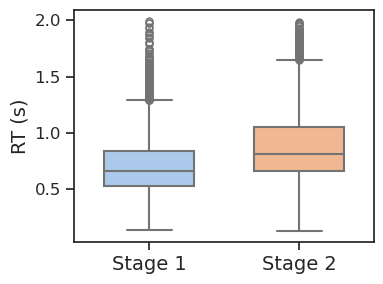

In [27]:
sns.set_theme(style="ticks")
plt.figure(figsize=(4, 3))

df_melted = df_empirical_data.melt(value_vars=['rt1', 'rt2'],
                                   var_name='Stage_orig', # Temporary name
                                   value_name='RT (seconds)')
df_melted['Stage'] = df_melted['Stage_orig'].map({'rt1': 'Stage 1', 'rt2': 'Stage 2'})


# 3. Create the boxplot using Seaborn - CORRECTED
sns.boxplot(
    x='Stage',
    y='RT (seconds)',
    data=df_melted,
    hue='Stage',         # <<< ASSIGN x VARIABLE TO hue
    palette="pastel",
    width=0.6,
    linewidth=1.5,
    fliersize=5,
    dodge=False        # Optional: if hue introduces dodging you don't want
)

#plt.title('Reaction Times in Stage 1 and Stage 2', fontsize=16, fontweight='bold', pad=15)
#plt.xlabel('Experimental Stage', fontsize=14)
plt.ylabel('RT (s)', fontsize=14)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

#sns.despine(trim=True, offset=10)
plt.tight_layout()
plt.show()

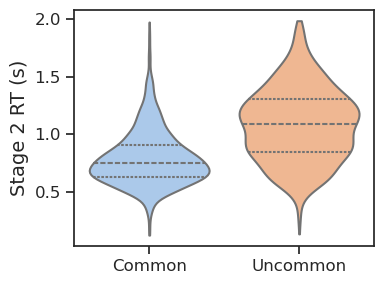

In [51]:
# 1. Set Seaborn style
sns.set_theme(style="ticks") # No grid, with ticks
plt.figure(figsize=(4, 3)) # Adjusted figsize slightly for violins

# 2. Prepare data for Seaborn
df_plot_data = df_empirical_data[['rt2', 'common']].copy()
df_plot_data['Transition Type'] = df_plot_data['common'].map({1: 'Common', 0: 'Uncommon'})

# 3. Create the VIOLIN PLOT using Seaborn
sns.violinplot(
    x='Transition Type',  # The column with 'Common' and 'Uncommon' labels
    y='rt2',              # The column with the RT values
    data=df_plot_data,
    hue='Transition Type',# Use 'Transition Type' for hue to get different colors per box
    order=['Common', 'Uncommon'], # Explicitly set the order of violins
    palette="pastel",     # Or any other palette you like
    linewidth=1.5,        # Linewidth for the violin body outline
    # --- Violin-specific and inner box customization ---
    inner="quartile",          # Draw a miniature boxplot inside
    cut=0,                # Truncate violins at data range
    density_norm="width",        # Violins have same max width
    legend=False,         # Hide legend as x-axis labels are sufficient
    dodge=False,          # No dodging needed
)

# Add title and labels
# plt.title('Stage 2 RT Distribution: Common vs Uncommon', fontsize=15, fontweight='bold', pad=15) # Updated title
plt.xlabel('') # No overall x-axis label
plt.ylabel('Stage 2 RT (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Apply despine as per the "ticks" style preference
#sns.despine(trim=True, offset=5)

plt.tight_layout()
plt.show()

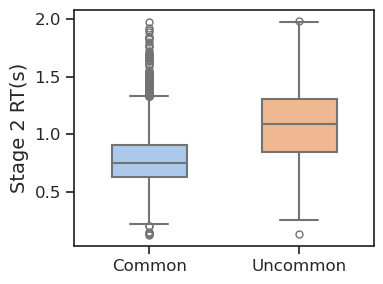

In [52]:
sns.set_theme(style="ticks") # No grid
plt.figure(figsize=(4, 3))   # Adjust as needed

# 2. Prepare data for Seaborn (Filter and add a descriptive column)
# We only need the 'rt2' and 'common' columns from the original DataFrame.
# We'll create a new column to hold the labels "Common" and "Uncommon".

df_plot_data = df_empirical_data[['rt2', 'common']].copy()
df_plot_data['Transition Type'] = df_plot_data['common'].map({1: 'Common', 0: 'Uncommon'})

# 3. Create the boxplot using Seaborn
sns.boxplot(
    x='Transition Type',  # The column with 'Common' and 'Uncommon' labels
    y='rt2',              # The column with the RT values
    data=df_plot_data,
    hue='Transition Type',# Use 'Transition Type' for hue to get different colors per box
    order=['Common', 'Uncommon'], # Explicitly set the order of boxes
    palette="pastel",     # Or any other palette you like
    width=0.5,
    linewidth=1.5,
    fliersize=5,
    legend=False,         # Hide legend as x-axis labels are sufficient
    dodge=False           # No dodging needed
)

# Add title and labels
#plt.title('Stage 2 RT (s)', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('') # No overall x-axis label, as 'Transition Type' labels are on the ticks
plt.ylabel('Stage 2 RT(s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Remove top and right spines if you prefer that look
# sns.despine(trim=True, offset=10) # Keep commented out for a full border

plt.tight_layout()
plt.show()


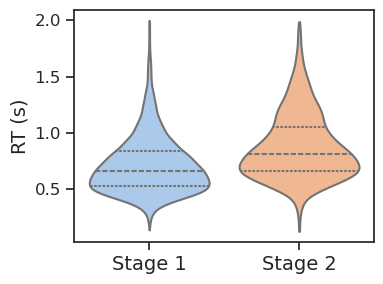

In [54]:
sns.set_theme(style="ticks") # Using "ticks" style
plt.figure(figsize=(4, 3)) # Slightly adjusted figsize for violins

# Reshape data for Seaborn (long format is preferred)
df_melted = df_empirical_data.melt(value_vars=['rt1', 'rt2'],
                                   var_name='Stage_orig', # Temporary name
                                   value_name='RT (seconds)')
df_melted['Stage'] = df_melted['Stage_orig'].map({'rt1': 'Stage 1', 'rt2': 'Stage 2'})


# Create the VIOLIN PLOT using Seaborn
sns.violinplot(
    x='Stage',
    y='RT (seconds)',
    data=df_melted,
    hue='Stage',         # Assign x variable to hue for palette application
    palette="pastel",    # Or "Set2", "viridis", etc.
    order=['Stage 1', 'Stage 2'], # Explicitly set order
    linewidth=1.5,
    #inner="box",
    # --- Violin-specific parameters ---
    inner="quartile",    # Shows Q1, median, Q3 as lines inside the violin.
                         # Other options: "box", "stick", "point", None
    cut=0,               # Ensures violins don't extend past data range.
                         # Use 1 or 2 to extend them for a smoother look if desired.
    density_norm="width",       # How to scale the width of the violins.
                         # "area": violins have same area.
                         # "count": width scaled by number of observations.
                         # "width": violins have same Emax width.
    legend=False,        # Hide the hue legend as x-axis labels are sufficient
    dodge=False ,         # No dodging needed if x and hue are the same
)


# Add title and labels
# plt.title('RT Distribution: Stage 1 vs Stage 2', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('RT (s)', fontsize=14)
plt.xlabel('') # No overall x-axis label
plt.xticks(fontsize=14) # For "Stage 1", "Stage 2" labels
plt.yticks(fontsize=12)

# Optional: Despine for the "ticks" style often looks good
#sns.despine(trim=True, offset=5)

plt.tight_layout()
plt.show()